# Pair Selection (Clean Notebook)

This notebook scans an equity universe for cointegrated pairs and scores them.
It includes:
- Robust Engle–Granger test with multiple `trend` options (best p-value kept).
- Benjamini–Hochberg FDR filtering (configurable).
- Fallback view: show top pairs by raw p-value if none pass FDR.
- Half-life & spread diagnostics.
- Safe Parquet writing (patch for `pandas.period` Arrow extension).


In [14]:

# =========================
# Parameters
# =========================
PRICES_PARQUET = "../data/processed/close_1h.parquet"  # set to your path

# Selection parameters
MIN_LOOKBACK = 250
FDR_ALPHA = 0.10           # set 1.0 to disable BH-FDR
HL_MIN = 0.5
HL_MAX = 2000.0

DATE_FROM = None           # e.g., "2025-06-01"
DATE_TO = None             # e.g., "2025-11-30"


In [15]:

# =========================
# Imports & environment
# =========================
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd()
if (ROOT / "src").exists():
    sys.path.insert(0, str(ROOT))
elif (ROOT.parent / "src").exists():
    sys.path.insert(0, str(ROOT.parent))

# Arrow extension double-registration patch
try:
    import pyarrow as pa
    try:
        pa.unregister_extension_type("pandas.period")
    except Exception:
        pass
except Exception:
    pass

plt.rcParams["figure.figsize"] = (9, 3.5)
plt.rcParams["axes.grid"] = False


In [16]:

# =========================
# Helpers: Load & Save
# =========================
from typing import Tuple, Iterable, List
from itertools import combinations

def load_prices(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Prices parquet not found: {path}. "
                                "Set PRICES_PARQUET correctly or define `prices` in memory.")
    df = pd.read_parquet(path)
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True, errors="coerce")
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    df = df.sort_index().ffill().bfill().dropna(axis=1, how="any")
    return df

def save_parquet_safe(df, path, engine=None):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    try:
        df.to_parquet(path, engine=engine)
    except Exception as e:
        try:
            import pyarrow as pa
            try:
                pa.unregister_extension_type("pandas.period")
            except Exception:
                pass
        except Exception:
            pass
        try:
            df.to_parquet(path, engine="fastparquet")
        except Exception as e2:
            raise RuntimeError(f"Failed to write parquet to {path}: {e2}") from e


In [17]:

# =========================
# Stats helpers
# =========================
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

def ols_hedge_ratio(y, x):
    X = sm.add_constant(x.values)
    mdl = sm.OLS(y.values, X).fit()
    beta = float(mdl.params[1])
    alpha = float(mdl.params[0])
    return beta, alpha

def engle_granger_best_p(a, b):
    pvals = []
    for trend in ("c", "ct", "n"):
        try:
            pvals.append(coint(a, b, trend=trend)[1])
        except Exception:
            pvals.append(np.nan)
        try:
            pvals.append(coint(b, a, trend=trend)[1])
        except Exception:
            pvals.append(np.nan)
    p = float(np.nanmin(pvals))
    if np.isnan(p):
        p = 1.0
    return p

def half_life(spread):
    s = spread.dropna().values
    if s.size < 10:
        return np.nan
    ds = np.diff(s)
    s_lag = s[:-1]
    X = sm.add_constant(s_lag)
    try:
        res = sm.OLS(ds, X).fit()
        gamma = float(res.params[1])
    except Exception:
        return np.nan
    if gamma >= 0:
        return np.inf
    import math
    hl = -math.log(2.0) / gamma
    return max(1.0, hl)

def benjamini_hochberg(pvals, alpha=0.05):
    p = np.asarray(list(pvals), dtype=float)
    m = p.size
    order = np.argsort(p)
    p_sorted = p[order]
    thresh = (np.arange(1, m + 1) / m) * alpha
    ok = p_sorted <= thresh
    if not np.any(ok):
        return [False] * m
    k = np.max(np.where(ok)[0])
    cutoff = p_sorted[k]
    return (p <= cutoff).tolist()

def score_pair(pvalue, hl, spread_vol, hl_min=1.0, hl_max=250.0):
    pv_comp = -np.log10(max(float(pvalue), 1e-12)) if not np.isnan(pvalue) else -12.0
    if np.isinf(hl) or np.isnan(hl):
        hl_comp = -5.0
    else:
        mid = (hl_min + hl_max) / 2.0
        hl_comp = -abs(np.log(hl + 1.0) - np.log(mid + 1.0))
    if np.isnan(spread_vol) or spread_vol <= 0:
        sv_comp = -5.0
    else:
        sv_comp = np.log(spread_vol)
    return 1.5 * pv_comp + 1.0 * hl_comp + 0.5 * sv_comp


In [18]:

# =========================
# Core analysis (standalone)
# =========================
def analyze_pairs_nb(prices,
                     min_lookback=250,
                     pvalue_threshold=0.05,
                     hl_min=1.0,
                     hl_max=250.0,
                     verbose=False):
    assert isinstance(prices.index, pd.DatetimeIndex), "DatetimeIndex required"
    tickers = list(prices.columns)
    combos = list((a, b) for i,a in enumerate(tickers) for b in tickers[i+1:])
    results = []
    for a, b in combos:
        pair_df = pd.concat([prices[a], prices[b]], axis=1, keys=[a, b]).dropna()
        if pair_df.shape[0] < min_lookback:
            if verbose:
                print(f"skip {a}-{b}: overlap {pair_df.shape[0]} < {min_lookback}")
            continue
        y = pair_df[a]; x = pair_df[b]
        pval = engle_granger_best_p(y, x)
        try:
            beta, alpha = ols_hedge_ratio(y, x)
        except Exception:
            beta, alpha = np.nan, np.nan
        spread = y - (alpha + beta * x)
        hl = half_life(spread)
        sp_mean = float(spread.mean())
        sp_vol  = float(spread.std(ddof=0))
        sc = score_pair(pval, hl, sp_vol, hl_min=hl_min, hl_max=hl_max)
        results.append({
            "ticker_a": a, "ticker_b": b,
            "pvalue": float(pval) if not np.isnan(pval) else np.nan,
            "beta": float(beta) if not np.isnan(beta) else np.nan,
            "intercept": float(alpha) if not np.isnan(alpha) else np.nan,
            "half_life": float(hl) if not np.isnan(hl) else np.nan,
            "spread_mean": sp_mean, "spread_vol": sp_vol,
            "n_obs": int(pair_df.shape[0]), "score": float(sc)
        })
    res = pd.DataFrame(results)
    if res.empty:
        return res
    if pvalue_threshold < 1.0:
        res["fdr_reject"] = benjamini_hochberg(res["pvalue"].fillna(1.0).tolist(),
                                               alpha=pvalue_threshold)
    else:
        res["fdr_reject"] = True
    res = res.sort_values(["fdr_reject", "score", "pvalue"],
                          ascending=[False, False, True]).reset_index(drop=True)
    return res


In [19]:

# =========================
# Load prices
# =========================
prices = load_prices(PRICES_PARQUET)

if DATE_FROM or DATE_TO:
    prices = prices.loc[DATE_FROM:DATE_TO]

print(prices.shape)
prices.head()


(3494, 9)


Ticker,BAC,BK,C,GS,JPM,MS,PNC,USB,WFC
Datetime,,,,,,,,,
2023-10-18 15:30:00+02:00,27.920000,43.369999,40.639999,305.484985,146.850006,74.910004,117.120003,33.884998,41.669998
2023-10-18 16:30:00+02:00,27.546000,43.435001,40.509899,303.239990,146.389999,74.190002,116.500000,33.733002,41.665001
2023-10-18 17:30:00+02:00,27.520000,43.259998,40.369999,302.864990,146.199997,74.084999,116.356400,33.744999,41.549999
2023-10-18 18:30:00+02:00,27.565001,43.430000,40.445000,303.122314,146.690002,74.570099,116.980003,33.759998,41.555000
2023-10-18 19:30:00+02:00,27.480000,43.389999,40.419998,303.279999,146.399994,74.650002,116.754997,33.717999,41.509998


In [20]:

# =========================
# Diagnostics: raw p-values (no FDR)
# =========================
rows = []
cols = list(prices.columns)
from itertools import combinations
for a,b in combinations(cols, 2):
    df = pd.concat([prices[a], prices[b]], axis=1).dropna()
    if len(df) < MIN_LOOKBACK:
        continue
    p = engle_granger_best_p(df[a], df[b])
    rows.append({"a":a,"b":b,"n":len(df),"pval":float(p)})
raw = pd.DataFrame(rows).sort_values("pval").reset_index(drop=True)
display(raw.head(12))
display(raw["pval"].describe())


,a,b,n,pval
0,GS,JPM,3494,0.010796
1,BK,GS,3494,0.018519
2,JPM,WFC,3494,0.034075
3,JPM,MS,3494,0.037995
4,PNC,USB,3494,0.052543
5,BAC,GS,3494,0.060362
6,BAC,MS,3494,0.078179
7,JPM,USB,3494,0.094431
8,MS,WFC,3494,0.099260
9,BK,JPM,3494,0.109665


count    36.000000
mean      0.242460
std       0.206742
min       0.010796
25%       0.107064
50%       0.179992
75%       0.297629
max       0.829308
Name: pval, dtype: float64

In [21]:

# =========================
# Run analysis (with FDR), plus fallback shortlist if none pass
# =========================
pairs = analyze_pairs_nb(prices, min_lookback=MIN_LOOKBACK,
                         pvalue_threshold=FDR_ALPHA, hl_min=HL_MIN, hl_max=HL_MAX)
display(pairs.head(20))

if pairs.empty or not pairs["fdr_reject"].any():
    cand = (raw
            .query("pval == pval and pval < 0.20")
            .sort_values(['pval'], ascending=True)
            .head(10))
    print("No pairs passed FDR. Showing top-10 by raw p-value (<0.20):")
    display(cand)


,ticker_a,ticker_b,pvalue,beta,intercept,half_life,spread_mean,spread_vol,n_obs,score,fdr_reject
0,GS,USB,0.208402,21.493883,-414.799259,935.174075,-1.624284e-13,92.663504,3494,3.218933,False
1,JPM,USB,0.094431,7.354475,-96.353987,856.241174,2.977853e-13,33.642467,3494,3.139938,False
2,JPM,PNC,0.224494,1.646277,-57.085525,1168.126515,7.101035e-13,24.920198,3494,2.426026,False
3,BK,USB,0.184908,2.806622,-49.862523,1253.582406,-8.902324e-14,13.651310,3494,2.180929,False
4,GS,JPM,0.010796,2.800421,-105.563834,94.031172,9.870647e-13,19.525310,3494,2.081137,False
5,MS,USB,0.261498,4.141256,-68.904514,840.889836,-5.955707e-13,15.682650,3494,2.076720,False
6,GS,PNC,0.601528,4.758758,-290.984708,1697.240221,4.352247e-13,67.057003,3494,1.905544,False
7,JPM,WFC,0.034075,3.588276,-5.006174,143.128790,6.950060e-14,11.412242,3494,1.480385,False
8,GS,WFC,0.231397,9.958386,-113.763384,219.691015,-2.330222e-12,40.961048,3494,1.297533,False
9,JPM,MS,0.037995,1.904769,11.483116,131.148383,-3.309738e-13,9.754965,3494,1.244218,False


No pairs passed FDR. Showing top-10 by raw p-value (<0.20):


,a,b,n,pval
0,GS,JPM,3494,0.010796
1,BK,GS,3494,0.018519
2,JPM,WFC,3494,0.034075
3,JPM,MS,3494,0.037995
4,PNC,USB,3494,0.052543
5,BAC,GS,3494,0.060362
6,BAC,MS,3494,0.078179
7,JPM,USB,3494,0.094431
8,MS,WFC,3494,0.099260
9,BK,JPM,3494,0.109665


In [22]:

# =========================
# Save outputs (optional)
# =========================
OUT_DIR = Path("../data/processed/pair_selection")
OUT_DIR.mkdir(parents=True, exist_ok=True)
if 'pairs' in globals() and not pairs.empty:
    save_parquet_safe(pairs, OUT_DIR / "pairs_results.parquet")
if 'raw' in globals() and not raw.empty:
    save_parquet_safe(raw, OUT_DIR / "pairs_raw_pvalues.parquet")
print("Saved to:", OUT_DIR)


Saved to: ..\data\processed\pair_selection


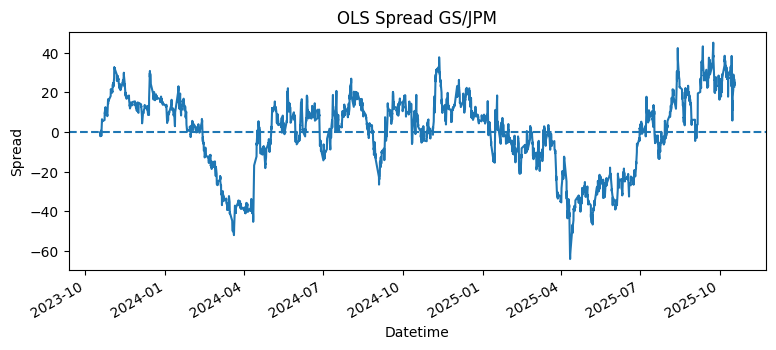

In [23]:

# =========================
# Quick visualization of OLS spread for a chosen pair
# =========================
def plot_spread(prices, a, b):
    df = pd.concat([prices[a], prices[b]], axis=1).dropna()
    if len(df) < MIN_LOOKBACK:
        print(f"Not enough overlap for {a}-{b}")
        return
    beta, alpha = ols_hedge_ratio(df[a], df[b])
    sp = df[a] - (alpha + beta * df[b])
    ax = sp.plot(title=f"OLS Spread {a}/{b}")
    ax.axhline(sp.mean(), linestyle="--")
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Spread")
    plt.show()

# Example: plot the best FDR-passed pair if available
if 'pairs' in globals() and not pairs.empty and pairs['fdr_reject'].any():
    top = pairs.query("fdr_reject").iloc[0]
    plot_spread(prices, top['ticker_a'], top['ticker_b'])
elif 'raw' in globals() and not raw.empty:
    top = raw.iloc[0]
    plot_spread(prices, top['a'], top['b'])
